In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [38]:
configs = {
    "batch_size" : 128,
    "max_file_count" : 2179,
    "train_file" : 6,
    "validation_file" : 3,
    "test_file" : 3,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 3e-4,
    "scheduler_factor": 0.8,
    "scheduler_patience": 3,
    "scheduler_min_lr": 2e-5,
    "epoch" : 30,
    "model_name" : "Transformer1",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35284 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/32122 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/27269 [00:00<?, ?it/s]

In [76]:
torch.set_default_dtype(torch.float32)
class StockTransformer(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.batch_size = configs["batch_size"]
        self.layer1 = torch.nn.Transformer(
            d_model = 1,
            nhead = 1,
            num_encoder_layers=6,
            num_decoder_layers=6,
            dim_feedforward=2048,
            dropout=0.1,
            custom_encoder=None,
            custom_decoder=None,
            layer_norm_eps=1e-05,
            batch_first=True,
            norm_first=False,
            bias=True,
        )
        self.data_scaler = 25

    def forward(self, input) :
        input = torch.multiply(input,self.data_scaler)

        decoder_input = torch.zeros(input.shape[0],1,1).to(device)
        output = self.layer1(input,decoder_input).reshape(-1,1)

        output = torch.divide(output,self.data_scaler)
        return output


In [42]:
model = StockTransformer()
model = model.to(device)

print(summary(model,input_size=(configs["batch_size"],configs["input_size"],1)))

Layer (type:depth-idx)                             Param #
├─Transformer: 1-1                                 --
|    └─TransformerEncoder: 2-1                     --
|    |    └─ModuleList: 3-1                        36,942
|    |    └─LayerNorm: 3-2                         2
|    └─TransformerDecoder: 2-2                     --
|    |    └─ModuleList: 3-3                        37,002
|    |    └─LayerNorm: 3-4                         2
Total params: 73,948
Trainable params: 73,948
Non-trainable params: 0
Layer (type:depth-idx)                             Param #
├─Transformer: 1-1                                 --
|    └─TransformerEncoder: 2-1                     --
|    |    └─ModuleList: 3-1                        36,942
|    |    └─LayerNorm: 3-2                         2
|    └─TransformerDecoder: 2-2                     --
|    |    └─ModuleList: 3-3                        37,002
|    |    └─LayerNorm: 3-4                         2
Total params: 73,948
Trainable params: 73,94

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)
loss_fn = torch.nn.L1Loss()

In [45]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "Transformer.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014558426355096427
val loss :  0.012834701176732778


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014558168117972937
val loss :  0.012840851873159408


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014556207172572612
val loss :  0.012839309353381395


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.01456552880731496
val loss :  0.01283481189981103


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014559601023793221
val loss :  0.012836536277085543


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014561037434773012
val loss :  0.012834876459091902


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014559041840786284
val loss :  0.012832747217267751


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.01456374627622691
val loss :  0.01283489478379488


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014566124325448817
val loss :  0.012839218970388174


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014556193619289181
val loss :  0.012831300806254149


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014557787958871235
val loss :  0.012837437730282545


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014561058858578856
val loss :  0.012827929962426423


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.01455634900114753
val loss :  0.012841517433524132


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014562604552642865
val loss :  0.012831653703004122


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014557357054542412
val loss :  0.012839432764798403


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014553425948728214
val loss :  0.012838947519659995


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.0145569232377139
val loss :  0.012828549936413764


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.01455891499465162
val loss :  0.012831546425819396


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.01456124728714878
val loss :  0.012824166886508465


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014567848840220408
val loss :  0.01283201254159212


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014560257724740289
val loss :  0.012836681753396988


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014560345279222184
val loss :  0.012836600381881


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.01456296537748792
val loss :  0.012843127578496934


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014557242898101156
val loss :  0.012829068876802921


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014563924632966518
val loss :  0.012837237667292356


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014563101391223344
val loss :  0.012828332845121622


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014556371904909611
val loss :  0.012826643392443656


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014549847350201824
val loss :  0.012838481117039918


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.014559388560327617
val loss :  0.012832755658775568


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

train loss :  0.01455634174699133
val loss :  0.012836815923452377


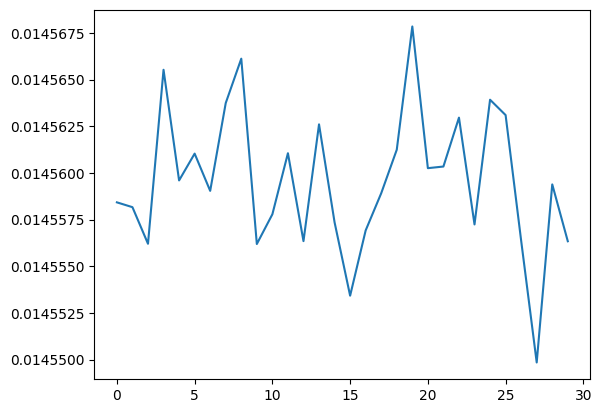

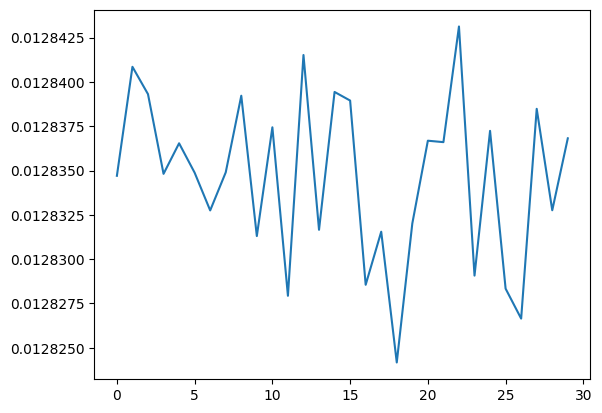

In [46]:
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [47]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [77]:
best_model = StockTransformer()
# best_model.load_state_dict(torch.load(configs["model_folder"] + "Transformer.pth.tar")['model'])

best_model.to(device)
best_model.eval()    

c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


StockTransformer(
  (layer1): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1, out_features=1, bias=False)
          )
          (linear1): Linear(in_features=1, out_features=2048, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=1, bias=False)
          (norm1): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
           

In [78]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/214 [00:00<?, ?it/s]

0.013005739187235844


In [79]:
def get_log_stock_prediction(model, stock_files) :
    model.eval()
    data_set = StockDatasetLogReturn(stock_files, configs["input_size"], 1)
    data_set.Preprocess()
    data_loader = DataLoader(data_set,configs["batch_size"])
    predict_res = []
    target_res = []
    
    with torch.no_grad() : 
        
        for input,target in tqdm(data_loader) :
            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)

            output = model(close_price_input)

            close_price_input = close_price_input.to(torch.device("cpu"))
            
            predict_res += output.to(torch.device("cpu")).reshape(-1).tolist()
            target_res += close_price_target.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [80]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [81]:
predict,target = get_log_stock_prediction(best_model, ["./data/A.csv"])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6129 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

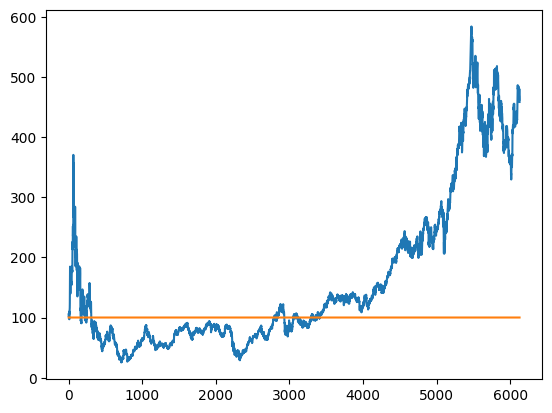

In [82]:
predict_percent = np.exp(predict)
target_percent = np.exp(target)
predict_plot = np.cumprod(predict_percent) * 100
target_plot = np.cumprod(target_percent) * 100
plt.plot(target_plot)
plt.plot(predict_plot)
plt.show()

In [74]:
total_profit = trade_test(predict,target)
print("total_profit : ",total_profit)
buy_and_hold_profit = trade_test(np.ones(target.shape),target)
print("buy and hold : ",buy_and_hold_profit)
random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
print("random profit : ",random_profit)

total_profit :  1.0
buy and hold :  4.5820224637360205
random profit :  3.4440339153083004


[]

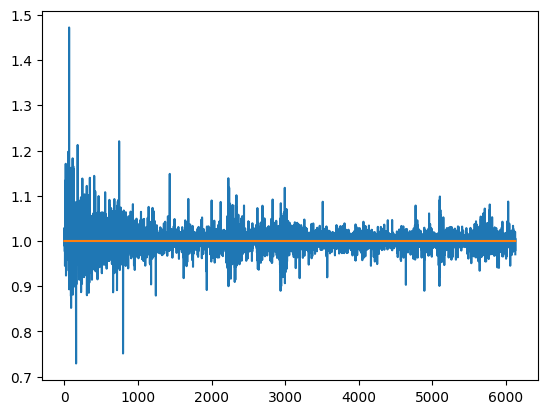

In [62]:
plt.plot(target_percent)
plt.plot(predict_percent)
plt.plot()

In [63]:
print(np.mean((np.log(np.array(target_percent)) * np.log(np.array(predict_percent))) > 0))

0.4780551476586719


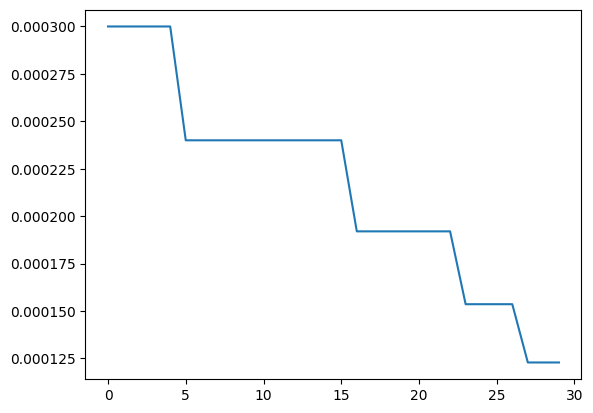

In [64]:
plt.plot(learning_rates)
plt.show()